In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from load_quasr_data import prepare_data_from_config
from diffusion_for_fusion.ddpm_fusion import from_standard
import seaborn as sns

plt.rc('font', family='serif')
# plt.rc('text.latex', preamble=r'\\usepackage{amsmath,bm}')
plt.rcParams.update({'font.size': 14})
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", 
          "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]

/Users/mpadidar/code/ml/diffusion_for_fusion/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# # conditioned on (iota, aspect) for nfp=4, helicity=1;  trained on PCA-9
# indir = "./output/mean_iota_aspect_ratio/run_uuid_4123533c-960a-411b-9ff0-2a990e3eb305"
# conditioned on (iota, aspect, nfp, helicity); trained on PCA-9
# indir = "output/mean_iota_aspect_ratio_nfp_helicity/run_uuid_da5a3230-deca-4709-a775-76b7365fbbd2"
# conditioned on (iota, aspect, nfp, helicity); trained on PCA-50 w/ big model
indir = "output/mean_iota_aspect_ratio_nfp_helicity/run_uuid_0278f98c-aaff-40ce-a7cd-b21a6fac5522"

mean_iota = 1.5
aspect_ratio = 12.0
nfp = 4
helicity = 1
use_local_pca = True
n_local_pca = 3

sample_filename = indir + f"/evaluations_samples_iota_{mean_iota}_aspect_{aspect_ratio}_nfp_{nfp}_helicity_{helicity}_local_pca_{use_local_pca}_{n_local_pca}.pickle"
actuals_filename = indir + f"/evaluations_actual_iota_{mean_iota}_aspect_{aspect_ratio}_nfp_{nfp}_helicity_{helicity}_local_pca_{use_local_pca}_{n_local_pca}.pickle"
config_pickle = indir + "/config.pickle"

In [3]:
# load the config
with open(config_pickle, 'rb') as f:
    data = pickle.load(f)
    config = data['config']

# load and standardize data
X_train, X_mean, X_std, Y_train, Y_mean, Y_std, pca = prepare_data_from_config(config)
Y_train = from_standard(Y_train, Y_mean, Y_std)


Taking PCA of data
Percent explained variance: 0.9991982130961038



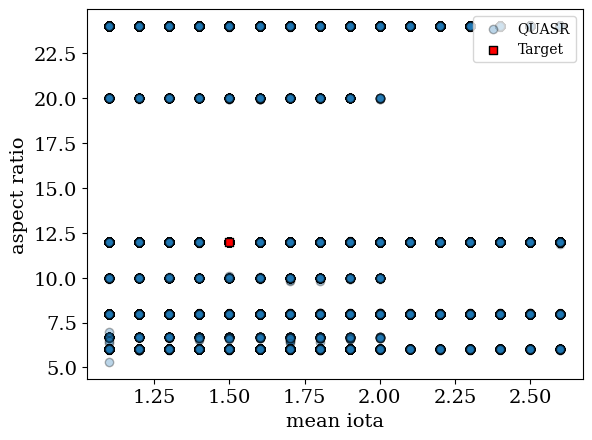

In [4]:
# plot iota, aspect from QUASR
idx_subset = ((Y_train[:,2] == nfp) & (Y_train[:,3] == helicity))
plt.scatter(Y_train[idx_subset,0], Y_train[idx_subset,1], color=colors[0], alpha=0.3, edgecolors='k', label='QUASR')
plt.scatter(mean_iota, aspect_ratio, color='r', alpha=1.0, edgecolors='k', marker='s', label='Target')

plt.xlabel('mean iota')
plt.ylabel('aspect ratio')
plt.legend(loc='upper right', fontsize=10)

In [5]:
# subset the data the same way we did in evaluate_model

idx_subset = ((np.abs(Y_train[:,0] - mean_iota)/mean_iota < 0.01) & (np.abs(Y_train[:,1] - aspect_ratio)/aspect_ratio < 0.01) & 
              (Y_train[:,2] == 4) & (Y_train[:,3] == 1))
X_train = X_train[idx_subset]
Y_train = Y_train[idx_subset]

In [6]:
# load samples from diffusion model
with open(sample_filename, 'rb') as f:
    data = pickle.load(f)
X_samples = data['X_samples']
Y_samples = data['Y_samples']
Y_pca = data.get('Y_pca', None)
Y_cond =  data['Y_conditions'].numpy()

In [7]:
# VMEC failures
# drop eval failures
idx_keep = np.all(Y_samples !=0.0, axis=1)
Y_samples = Y_samples[idx_keep]
Y_cond = Y_cond[idx_keep]
print(f"VMEC failed on {100 - 100*np.mean(idx_keep)}% of evaluations")

VMEC failed on 37.109375% of evaluations


In [8]:
# load actuals
with open(actuals_filename, 'rb') as f:
    data = pickle.load(f)
X_actuals = data['X']
Y_actuals = data['Y']
# drop VMEC failures
idx_keep = np.all(Y_actuals !=0.0, axis=1)
Y_actuals = Y_actuals[idx_keep]
print(f"VMEC failed on {100 - 100*np.mean(idx_keep)}% of evaluations")

VMEC failed on 39.84375% of evaluations


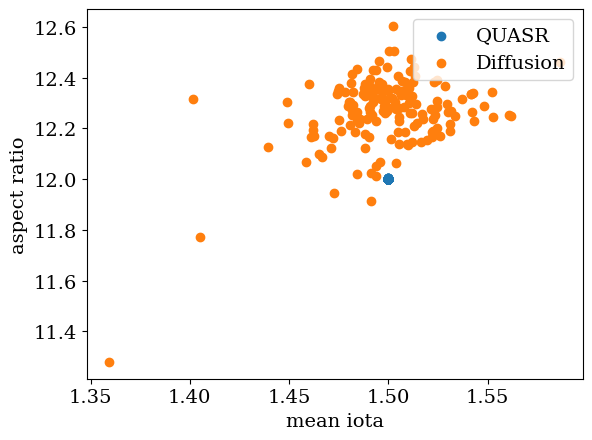

In [9]:
# plot iota, aspect
plt.scatter(Y_train[:,0], Y_train[:,1], label='QUASR')
plt.scatter(Y_samples[:,1], Y_samples[:,2], label='Diffusion')
# plt.scatter(Y_cond[:,1], Y_cond[:,2], label='condition')

plt.xlabel('mean iota')
plt.ylabel('aspect ratio')
plt.legend(loc='upper right')

Text(0.5, 1.0, 'iota 1.5, aspect 12.0, nfp 4, helicity 1')

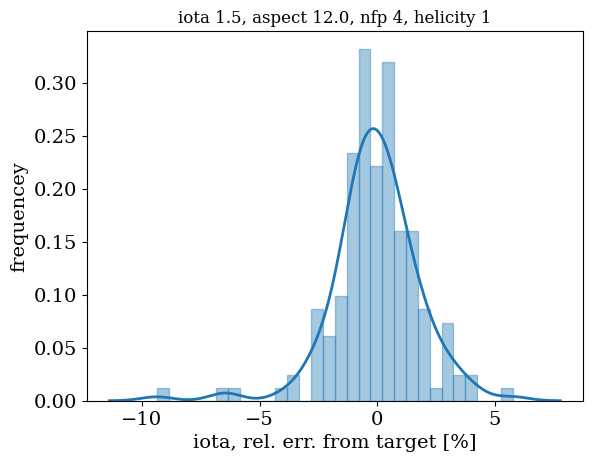

In [10]:
# iota vs target iota

err = 100 * (Y_samples[:,1] - Y_cond[:,0]) / Y_cond[:,0]
plt.hist(err, bins=30, alpha=0.4, color=colors[0], edgecolor=colors[0], density=True)
sns.kdeplot(err, color=colors[0], lw=2)
plt.xlabel('iota, rel. err. from target [%]')
plt.ylabel('frequencey')
plt.title(f'iota {mean_iota}, aspect {aspect_ratio}, nfp {nfp}, helicity {helicity}', fontsize=12)

Text(0.5, 1.0, 'iota 1.5, aspect 12.0, nfp 4, helicity 1')

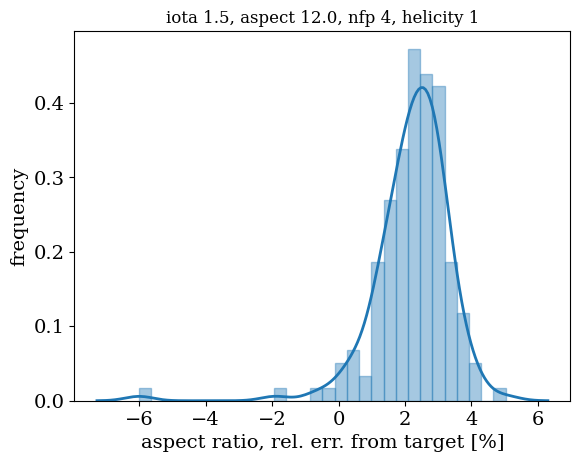

In [11]:
# aspect vs target aspect

err = 100 * (Y_samples[:,2] - Y_cond[:,1]) / Y_cond[:,1]
plt.hist(err, bins=30, alpha=0.4, color=colors[0], edgecolor=colors[0], density=True)
sns.kdeplot(err, color=colors[0], lw=2)
plt.xlabel('aspect ratio, rel. err. from target [%]')
plt.ylabel('frequency')
plt.title(f'iota {mean_iota}, aspect {aspect_ratio}, nfp {nfp}, helicity {helicity}', fontsize=12)

QS Error
0.25 quantile 0.03142648977783775
0.50 quantile 0.12117027677946712
0.75 quantile 0.03142648977783775


Text(0.5, 1.0, 'iota 1.5, aspect 12.0, nfp 4, helicity 1')

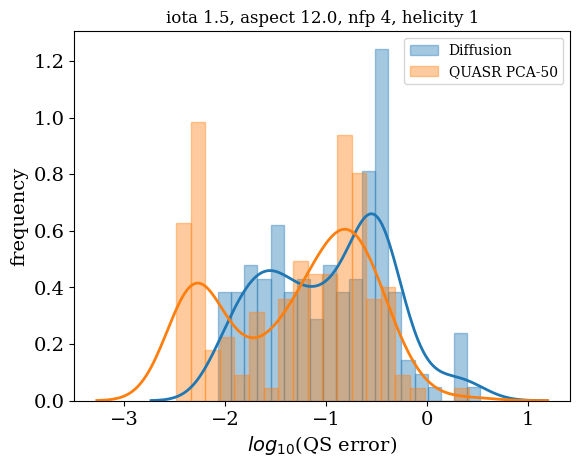

In [12]:
# quasisymmetry of samples
print('QS Error')
print('0.25 quantile', np.quantile(Y_samples[:,0], 0.25))
print('0.50 quantile', np.quantile(Y_samples[:,0], 0.5))
print('0.75 quantile', np.quantile(Y_samples[:,0], 0.25))


plt.hist(np.log10(Y_samples[:,0]), bins=20, alpha=0.4, color=colors[0], edgecolor=colors[0], density=True, label='Diffusion')
sns.kdeplot(np.log10(Y_samples[:,0]), color=colors[0], lw=2)
plt.hist(np.log10(Y_actuals[:,0]), bins=20, alpha=0.4, color=colors[1], edgecolor=colors[1], density=True, label='QUASR PCA-50')
sns.kdeplot(np.log10(Y_actuals[:,0]), color=colors[1], lw=2)
plt.xlabel('$log_{10}$(QS error)')
plt.ylabel('frequency');
plt.legend(loc='upper right', fontsize=10)
plt.title(f'iota {mean_iota}, aspect {aspect_ratio}, nfp {nfp}, helicity {helicity}', fontsize=12)